In [1]:
from glob import glob
from os.path import basename, isfile
import pandas as pd
from re import search
import numpy as np
import cv2
from cv2.aruco import extendDictionary, CORNER_REFINE_SUBPIX, DetectorParameters

In [2]:
bilder = pd.DataFrame(glob(
    "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/**/*.jpg"), columns=["path"])
bilder["camera"] = [int(basename(path)[6:8]) for path in bilder["path"]]
bilder["focus"] = [
    float(search("(?<=\/F)\d{2}(?=\/)", i).group()) for i in bilder["path"]]
bilder["image"] = bilder.index
bilder.set_index("image", inplace=True)
bilder

,path,camera,focus
image,,,
0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
1,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,1.0
2,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,3,1.0
3,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,4,1.0
4,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,5,1.0
...,...,...,...
133,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,20,10.0
134,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,21,10.0
135,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,22,10.0


In [3]:
cameras = pd.DataFrame(bilder["camera"].unique(), columns=["camera"])
cameras.set_index("camera", inplace=True)
cameras[["tx", "ty", "tz", "rx", "ry", "rz", "wcx", "wcy", "wcz"]] = None
cameras

,tx,ty,tz,rx,ry,rz,wcx,wcy,wcz
camera,,,,,,,,,
1,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None,None
6,None,None,None,None,None,None,None,None,None
7,None,None,None,None,None,None,None,None,None
9,None,None,None,None,None,None,None,None,None
10,None,None,None,None,None,None,None,None,None


In [4]:
sift = cv2.SIFT_create()  # type: ignore

for img_id, img in bilder.iterrows():
    if isfile(img["path"] + '.npz'):
        continue
    # Load the image
    image = cv2.imread(img["path"])

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect SURF keypoints and compute descriptors
    kp, des = sift.detectAndCompute(gray, None)
    pt = np.array([n.pt for n in kp])
    np.savez_compressed(img["path"] + '.npz', des=des, pt=pt)

In [5]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)


def match(image1: str, image2: str):
    data1 = np.load(image1 + '.npz')
    data2 = np.load(image2 + '.npz')
    k1, d1 = data1["pt"], data1["des"]
    k2, d2 = data2["pt"], data2["des"]

    matches = flann.knnMatch(d1, d2, k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < 0.7*n.distance and np.linalg.norm(k1[m.queryIdx]-k2[m.trainIdx], ord=1) < 200:
            good.append([m.queryIdx, m.trainIdx])
    return good

In [6]:
vk = bilder.reset_index().assign(key=1).merge(bilder.reset_index().assign(key=1), on='key',
                                              suffixes=('1', '2')).drop('key', axis=1)
vk = vk[vk["image1"] < vk["image2"]]
vk = vk[(abs(vk["camera1"] - vk["camera2"]) < 6) |
        (abs(vk["camera1"] - vk["camera2"]) > 18)]
vk

,image1,path1,camera1,focus1,image2,path2,camera2,focus2
1,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,1,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,1.0
2,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,2,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,3,1.0
3,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,3,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,4,1.0
4,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,4,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,5,1.0
5,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,5,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,6,1.0
...,...,...,...,...,...,...,...,...
18628,134,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,21,10.0,136,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,23,10.0
18629,134,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,21,10.0,137,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,10.0
18766,135,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,22,10.0,136,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,23,10.0
18767,135,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,22,10.0,137,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,10.0


In [7]:
verknuepfungen: pd.DataFrame
try:
    verknuepfungen = pd.read_csv(
        "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/verknuepfungen.csv")

except FileNotFoundError:
    verknuepfungen_list: list = []
    for _, row in vk.iterrows():
        if row['id1'] > row['id2']:
            continue
        # print(row['id1'], row['id2'])
        matches = match(row["path1"], row["path2"])
        for m in matches:
            verknuepfungen_list.append([row["id1"], m[0], row["id2"], m[1]])

    verknuepfungen = pd.DataFrame(
        verknuepfungen_list, columns=["id1", "idx1", "id2", "idx2"])
    verknuepfungen.to_csv(
        "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/verknuepfungen.csv", index=False)

In [8]:
verknuepfungen["pid"] = verknuepfungen.index
verknuepfungen

,id1,idx1,id2,idx2,pid
0,0,4092,1,3602,0
1,0,18657,1,7758,1
2,0,18728,1,7795,2
3,0,18800,1,7800,3
4,0,18844,1,7846,4
...,...,...,...,...,...
111534,133,241,134,382,111534
111535,133,251,134,388,111535
111536,133,256,134,388,111536
111537,133,261,134,401,111537


In [9]:
pp: pd.DataFrame
try:
    pp = pd.read_csv(
        "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/passpunkte.csv")
except:
    for i, _ in verknuepfungen.iterrows():
        row = verknuepfungen.iloc[i]
        # if row.pid % 2000 == 0:
        #    print(i)
        verknuepfungen.loc[(verknuepfungen.pid > row.pid) & (
            verknuepfungen.id1 == row.id2) & (verknuepfungen.idx1 == row.idx2), 'pid'] = row.pid

    pp = pd.concat([verknuepfungen[["pid", "id1", "idx1"]].rename(columns={"id1": "id", "idx1": "idx"}),
                    verknuepfungen[["pid", "id2", "idx2"]].rename(columns={"id2": "id", "idx2": "idx"})])
    pp.drop_duplicates(inplace=True)
    pp.to_csv(
        "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/passpunkte.csv")

In [10]:
pp.rename(columns={"pid": "point_id", "id": "image",
          "idx": "point_idx"}, inplace=True)
pp.rename(columns={"Unnamed: 0": "id"}, inplace=True)
pp.reset_index(drop=True, inplace=True)
pp.set_index("id", inplace=True)
pp

,point_id,image,point_idx
id,,,
0,0,0,4092
1,1,0,18657
2,2,0,18728
3,3,0,18800
4,4,0,18844
...,...,...,...
111527,111527,134,319
111530,31165,134,354
111535,111535,134,388


In [11]:
joined_df = pp.merge(bilder, on='image').sort_values(["camera", "point_idx"])
xy = []
joined_df

,point_id,image,point_idx,path,camera,focus
81985,92275,69,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,5.0
95139,71422,92,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,6.0
113730,71658,115,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,10.0
113783,71249,115,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,10.0
58049,71422,46,1,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,4.0
...,...,...,...,...,...,...
81965,70116,68,7866,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0
81966,70117,68,7871,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0
81968,70119,68,7882,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0
81967,70118,68,7887,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0


In [12]:
pts_ = []
for i, row in bilder.iterrows():
    l = np.load(file=row["path"] + '.npz')["pt"]
    [pts_.append([i, n, p[0], p[1]]) for n, p in enumerate(l)]
pts = pd.DataFrame(pts_, columns=["image", "point_idx", "x", "y"])

In [13]:
pts

,image,point_idx,x,y
0,0,0,2.412978,1667.347290
1,0,1,3.420322,2537.289795
2,0,2,3.420322,2537.289795
3,0,3,4.687777,2574.825195
4,0,4,5.092439,1510.068115
...,...,...,...,...
866602,137,1420,4527.503906,1032.616089
866603,137,1421,4537.976562,2236.974121
866604,137,1422,4541.773438,959.387695
866605,137,1423,4548.978027,1071.667358


In [14]:
joined_df = joined_df.merge(pts, on=["image", "point_idx"])
joined_df

,point_id,image,point_idx,path,camera,focus,x,y
0,92275,69,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,5.0,37.025242,1373.879028
1,71422,92,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,6.0,37.656891,1085.415527
2,71658,115,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,10.0,163.523376,1202.720093
3,71249,115,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,10.0,163.523376,1202.720093
4,71422,46,1,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,4.0,47.113457,1087.628296
...,...,...,...,...,...,...,...,...
123648,70116,68,7866,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0,4597.042480,2018.774902
123649,70117,68,7871,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0,4597.765137,1977.595459
123650,70119,68,7882,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0,4599.907227,2000.318848
123651,70118,68,7887,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0,4600.082520,2073.079346


In [15]:
coords = pd.read_csv(
    "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/marker.txt", sep=";", header=2, names=["marker", "wx", "wy", "wz"])
coords.set_index("marker", inplace=True)
coords.dropna(inplace=True)
coords

,wx,wy,wz
marker,,,
71,-0.067445,0.326679,0.028320
72,-0.093609,0.305970,0.028604
73,-0.093261,0.305538,0.062565
30,-0.211562,0.202564,0.062370
31,-0.211726,0.202705,0.028728
...,...,...,...
193,0.463443,-0.074490,0.357178
160,0.399303,0.195902,0.175359
161,0.375965,0.220108,0.175731


In [16]:
aruco_dict = extendDictionary(32, 3)
parameter = DetectorParameters()
parameter.cornerRefinementMethod = CORNER_REFINE_SUBPIX
LUT_IN = [0, 158, 216, 255]
LUT_OUT = [0, 22, 80, 176]
lut = np.interp(np.arange(0, 256),
                LUT_IN, LUT_OUT).astype(np.uint8)
detector = cv2.aruco.ArucoDetector(aruco_dict, parameter)

In [17]:
liste = []

for img_id, img in bilder.iterrows():
    imgCV = cv2.imread(img.path)
    gray = cv2.cvtColor(imgCV, cv2.COLOR_BGR2GRAY)
    tmp_corners, tmp_ids, t = detector.detectMarkers(
        gray)

    if tmp_ids is None:
        continue
    for c, i in zip(tmp_corners, tmp_ids):
        for k in range(len(c[0])):
            m: int = i[0]*10+k
            x, y = c[0][k]
            liste.append([img_id, m, x, y])


aruco = pd.DataFrame(liste, columns=["image", "marker", "x", "y"])
aruco["id"] = aruco.index
aruco.set_index("id", inplace=True)
aruco[['inlier']] = False
aruco

,image,marker,x,y,inlier
id,,,,,
0,0,130,559.947083,928.506714,False
1,0,131,618.573547,1081.224731,False
2,0,132,463.065948,1176.444458,False
3,0,133,395.642670,1023.020630,False
4,0,70,2970.246582,477.649963,False
...,...,...,...,...,...
1051,114,103,2669.963867,477.010437,False
1052,114,70,1519.000000,1248.000000,False
1053,114,71,1517.000000,1403.000000,False


In [163]:
vz_param = [2.63572488e+01,  6.31322513e-01, -9.88069511e+00,  2.92706002e+01,
            -4.15690296e-03, -1.99188205e-02, -1.01408404e-04,  2.60612862e-06,
            2.79208519e-02]
# cameras[["df", "dcx", "dcy", "dff", "v1f", "v2f",
#         "v3f", "v4f", "v5f"]] = vz_param


def calibrate(f, parameter=vz_param, f_offset=0, x_offset=0, y_offset=0) -> tuple:
    x = parameter
    cameraMatrix = np.array(
        [[3385+x[0]+x[3]*f + f_offset, 0, 2304+x[1]+x_offset], [0, 3385+x[0]+x[3]*f + f_offset, 1296+x[2]+y_offset], [0, 0, 1]])
    distCoeffs = np.array([x[4:9]])*f
    return cameraMatrix, distCoeffs

In [19]:
def create_joined():
    mm = aruco.reset_index().merge(coords, on="marker").dropna().merge(
        bilder, on='image').merge(cameras, on='camera')
    mm.set_index("id", inplace=True)
    return mm


mm = create_joined()
mm

,image,marker,x,y,inlier,wx,wy,wz,path,camera,focus,tx,ty,tz,rx,ry,rz,wcx,wcy,wcz
id,,,,,,,,,,,,,,,,,,,,
0,0,130,559.947083,928.506714,False,-0.271953,-0.114972,0.062191,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,None,None,None,None,None,None,None,None,None
1,0,131,618.573547,1081.224731,False,-0.272443,-0.115302,0.028549,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,None,None,None,None,None,None,None,None,None
2,0,132,463.065948,1176.444458,False,-0.263960,-0.147964,0.028789,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,None,None,None,None,None,None,None,None,None
3,0,133,395.642670,1023.020630,False,-0.263656,-0.147620,0.062538,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,None,None,None,None,None,None,None,None,None
5,0,71,2950.927734,617.187866,False,-0.067445,0.326679,0.028320,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,108,63,1563.344849,1059.883057,False,0.465339,0.123830,0.062603,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,18,6.0,None,None,None,None,None,None,None,None,None
996,85,60,1721.000000,1068.000000,False,0.472215,0.090849,0.062837,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,18,5.0,None,None,None,None,None,None,None,None,None
997,85,61,1726.070435,1216.332764,False,0.472431,0.090633,0.028969,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,18,5.0,None,None,None,None,None,None,None,None,None


In [20]:
cameras[["tx", "ty", "tz", "rx", "ry", "rz"]] = None
aruco[['inlier']] = False

c = 3385
camMat = np.array([[c, 0, 0], [0, c, 0],
                  [0, 0, 1]], dtype=np.float64)

for i, m in mm.groupby('camera'):
    # print(m)
    if len(m) < 4:
        continue
    xy = []
    xyz = []
    for img_id, n in m.groupby('image'):
        xyz_ = n[['wx', 'wy', 'wz']].values
        xy_ = n[['x', 'y']].values
        camera_matrix, dist_coeffs = calibrate(
            n["focus"].values[0], vz_param)
        xy.append(cv2.undistortPoints(xy_, camera_matrix,
                  dist_coeffs,   P=camMat))
        xyz.append(xyz_)
    xy = np.concatenate(xy).reshape(-1, 2)
    xyz = np.concatenate(xyz).reshape(-1, 3)
    _, rvec, tvec, inliers = cv2.solvePnPRansac(
        xyz, xy, camMat, np.zeros(5), reprojectionError=10.0)
    cameras.loc[m['camera'].values[0], ["tx", "ty", "tz"]] = tvec.T[0]
    cameras.loc[m['camera'].values[0], ["rx", "ry", "rz"]] = rvec.T[0]
    indizes = m.index.to_numpy()
    for inl in inliers:
        aruco.loc[indizes[inl], 'inlier'] = True

len(aruco[aruco["inlier"]])

697

In [21]:
for key, p in cameras.iterrows():
    rt = p[['rx', 'ry', 'rz']].to_numpy(dtype=np.float64)
    R = cv2.Rodrigues(rt)[0]
    R = np.linalg.inv(R)
    t = p[['tx', 'ty', 'tz']].to_numpy(dtype=np.float64).T
    t = -R@t
    cameras.loc[key, ["wcx", "wcy", "wcz"]] = t
cameras

,tx,ty,tz,rx,ry,rz,wcx,wcy,wcz
camera,,,,,,,,,
1,-0.022604,0.04934,0.565571,2.115969,0.815842,-0.365761,0.284136,-0.298862,0.390851
2,-0.046744,0.055488,0.484177,1.901449,0.734072,-0.459741,0.31154,-0.278145,0.255479
3,-0.065895,0.079897,0.405305,1.413819,0.611008,-0.624436,0.338387,-0.239642,0.055349
4,0.017297,0.103264,0.572861,1.637034,1.598002,-0.862232,0.422424,-0.028897,0.399819
5,0.01694,0.076952,0.495608,1.490796,1.468722,-0.991083,0.431456,-0.02558,0.255005
6,0.019619,0.07415,0.421052,1.193771,1.170288,-1.216322,0.423006,-0.026094,0.059604
7,0.1062,0.126861,0.63011,1.015799,2.423819,-1.086532,0.339468,0.20119,0.518358
9,0.173913,0.068391,0.398223,1.142813,1.804959,-1.347934,0.397177,0.008482,0.188899
10,0.110531,0.13347,0.503027,-0.006512,2.847223,-1.335242,0.108518,0.301959,0.424397


In [22]:
import plotly.graph_objs as go

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=cameras['wcx'], y=cameras['wcy'],
                z=cameras['wcz'], mode='markers', name='Original Points')])

# Add labels to the plot
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title='Rotation and Translation Vectors in 3D')
fig.layout.scene.camera.projection.type = "orthographic"
fig.show()

In [23]:
daten = aruco[aruco["inlier"]].merge(bilder, on='image')
daten

,image,marker,x,y,inlier,path,camera,focus
0,0,131,618.573547,1081.224731,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
1,0,132,463.065948,1176.444458,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
2,0,72,2799.633789,608.245117,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
3,0,73,2812.600830,470.871674,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
4,0,30,2099.141357,454.248505,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0
...,...,...,...,...,...,...,...,...
692,108,13,2611.835205,317.767487,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,18,6.0
693,108,61,1726.000000,1220.000000,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,18,6.0
694,111,162,2462.391602,42.374474,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,21,6.0
695,111,150,1848.458862,824.978821,True,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,21,6.0


In [24]:
camPos = cameras[['rx', 'ry', 'rz', 'tx', 'ty', 'tz']
                 ].to_numpy(dtype=np.float64)
camPosIdx = cameras.index.to_numpy()
numCamParams = 6
numCams = len(camPosIdx)

In [25]:
pos = coords.to_numpy(dtype=np.float64)
posPosIdx = coords.index.to_numpy()
numPosParams = 3
numPos = len(posPosIdx)

In [26]:
def fun(x):
    diff = []
    x = np.array(x)
    cam_param = x[:9]
    cams = {id: values for id, values in zip(
        camPosIdx, x[9:numCamParams*numCams+9].reshape(-1, numCamParams))}
    posx = {id: values for id, values in zip(
        posPosIdx, x[numCamParams*numCams+9:].reshape(-1, numPosParams))}
    for i, row in daten.iterrows():
        cameraMatrix, distCoeffs = calibrate(
            row["focus"], cam_param)
        rvec = cams[row["camera"]][0:3]
        tvec = cams[row["camera"]][3:6]
        imgpoints, _ = cv2.projectPoints(
            np.array([posx[row["marker"]]], np.float32), rvec, tvec, cameraMatrix, distCoeffs)
        d_ = imgpoints[0][0]-row[['x', 'y']].values
        diff.append(np.linalg.norm(d_))

    for i in (pos - x[numCamParams*numCams+9:].reshape(-1, numPosParams)):
        diff.append(np.linalg.norm(i))

    return diff

In [27]:
x0 = np.hstack([vz_param, camPos.flatten(), pos.flatten()])

In [118]:
from scipy.sparse import lil_matrix
A = lil_matrix((len(daten)+len(pos), len(x0)), dtype=int)
for i, (key, row) in enumerate(daten.iterrows()):
    A[i, 0:9] = 1
    A[i, 9+np.where(camPosIdx == row["camera"])[0][0]*numCamParams +
        np.arange(numCamParams)] = 1
    A[i, 9+len(camPosIdx)*numCamParams +
        np.where(posPosIdx == row["marker"])[0][0]*numPosParams + np.arange(numPosParams)] = 1
for i in range(len(pos)):
    A[len(daten)+i, 9+len(camPosIdx)*numCamParams +
        i*numPosParams + np.arange(numPosParams)] = 1

In [119]:
np.array(fun(x0))

array([ 6.82650655,  7.82523117,  7.14585722,  4.90254356,  5.07685555,
        5.9139492 ,  5.27177757,  8.25128215,  6.46013881,  6.35485289,
        3.061526  ,  3.68698113,  8.46307447,  1.13041847,  3.93912148,
        3.33672923,  3.66149798,  5.72210645,  3.84252166,  2.46484762,
        1.68271418,  3.75212192,  5.21893237,  4.88497501,  3.13904945,
        3.24102941,  4.03956116,  4.37177229,  4.20224131,  2.81896398,
        3.76936848,  2.70139641,  2.21263595,  4.93090715,  5.60794294,
        5.83662163,  4.8448188 ,  2.6053171 ,  4.23500823,  5.76613708,
        5.49275677,  4.34519963,  3.99223072,  6.62524135,  1.70607282,
        5.55211556,  4.37264634,  2.0282062 ,  1.3629446 ,  6.10778695,
        0.8072801 ,  0.8325883 ,  2.14860307,  3.31657258,  4.55559884,
        4.96289762,  7.82481882,  6.42542101,  6.12956673,  6.12450105,
        6.11377879,  5.78882541,  3.18197131,  2.36553298,  3.74695505,
        1.19629189,  3.9931919 ,  1.76399092,  3.65593813,  5.06

In [120]:
from scipy.optimize import least_squares

res = least_squares(fun, x0, jac_sparsity=A, verbose=2,
                    x_scale='jac', method='trf', xtol=1e-5, loss='huber')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.2442e+03                                    3.20e+05    
       1             21         3.2380e+03      6.21e+00       2.09e-03       3.03e+05    
       2             22         3.2374e+03      5.31e-01       1.60e-04       2.79e+05    
`xtol` termination condition is satisfied.
Function evaluations 22, initial cost 3.2442e+03, final cost 3.2374e+03, first-order optimality 2.79e+05.


In [31]:
from scipy import linalg
jac = res.jac.todense()
cov = linalg.pinv(jac.T @ jac)
chi2dof = np.sum(res.fun**2)/(res.fun.size - res.x.size)
cov *= chi2dof
perr = np.sqrt(abs(np.diag(cov)))
perr

array([6.98033340e-08, 3.54252284e-07, 1.98149809e-07, 3.59764548e-08,
       1.87162044e+00, 3.33342342e-01, 2.19596690e+00, 8.48974164e-01,
       4.69071127e-08, 2.57686719e-08, 1.00696705e-07, 6.66515700e-08,
       1.02035207e-07, 2.45632970e-08, 1.15122758e-08, 4.93127689e-08,
       1.11002091e-07, 2.78317780e-08, 1.25427406e-07, 1.95582091e-08,
       5.07974808e-08, 7.45906029e-01, 1.05457644e+00, 1.16238201e-07,
       3.55527626e-08, 1.05477333e+00, 4.84497978e-08, 2.01120752e-07,
       4.57517716e-08, 2.88037098e-08, 1.23420684e-07, 1.17724895e+00,
       5.88788518e-01, 7.45598730e-01, 7.56804548e-01, 1.51598241e-01,
       1.90306644e+00, 2.15533076e+00, 1.51598365e-01, 6.41605254e-08,
       8.89019925e-08, 1.73455258e-08, 2.73934693e-07, 1.76837753e-07,
       4.36545182e-08, 2.29885812e-08, 3.64535786e-08, 2.32530153e-08,
       1.40169204e-07, 4.68785778e-08, 5.38067486e-08, 3.71291716e-10,
       2.50165641e-09, 1.90243816e-01, 2.56480110e-01, 5.12956353e-01,
      

In [32]:
res.x/perr

array([ 3.77592978e+08,  1.77677510e+06, -4.98647724e+07,  8.13604351e+08,
       -2.22101815e-03, -5.97548467e-02, -4.61793864e-05,  3.06973843e-06,
        5.96741304e+05,  8.21226065e+07,  8.10319464e+06, -5.47978304e+06,
       -2.21816457e+05,  2.00751188e+06,  4.91156354e+07,  3.85586856e+07,
        6.61285957e+06, -1.65173186e+07, -3.72601204e+05,  2.83454557e+06,
        9.53069287e+06,  1.89543910e+00,  5.79387179e-01, -5.37058052e+06,
       -1.85378077e+06,  7.57480011e-02,  8.36504030e+06,  8.14022636e+06,
        3.49301859e+07, -2.99397350e+07,  1.40149600e+05,  8.77159786e-02,
        9.72948741e-01,  1.99946206e+00,  1.94068925e+00, -6.53792982e+00,
        8.89213095e-03,  3.57030507e-02,  3.26922058e+00,  1.86074283e+07,
        1.31637162e+07, -7.01229450e+07,  7.17050277e+04,  4.19435539e+05,
        9.64462533e+06,  4.41860272e+07,  6.64944968e+07, -4.67254328e+07,
        7.57802627e+05,  2.70497735e+06,  1.17102981e+07,  3.07778132e+09,
        7.21500607e+08, -

In [33]:
vz_param - res.x[:9]

array([ 0.00000000e+00,  1.89587305e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.46944695e-18, -5.14996032e-19, -2.42674939e-19,
       -7.05597001e-05])

In [34]:
pd.DataFrame(perr[numCamParams *
                  numCams+9:].reshape(-1, numPosParams))

,0,1,2
0,2.625726,2.626231,2.625425
1,2.626222,2.625400,2.625622
2,2.630824,2.629717,2.630605
3,2.627928,2.627187,2.626800
4,2.749767,3.806334,1.337266
...,...,...,...
78,2.625245,2.625245,2.625245
79,2.626280,2.625787,2.626195
80,2.474862,3.061898,2.401072
81,2.625685,2.625788,2.625390


In [35]:
vz_param = res.x[0:9]
cameras[['rx', 'ry', 'rz', 'tx', 'ty', 'tz']
        ] = res.x[9:9+numCamParams*numCams].reshape(-1, numCamParams)
coords[['wx', 'wy', 'wz']] = res.x[numCamParams *
                                   numCams+9:].reshape(-1, numPosParams)
for key, p in cameras.iterrows():
    rt = p[['rx', 'ry', 'rz']].to_numpy(dtype=np.float64)
    R = cv2.Rodrigues(rt)[0]
    R = np.linalg.inv(R)
    t = p[['tx', 'ty', 'tz']].to_numpy(dtype=np.float64).T
    t = -R@t
    cameras.loc[key, ["wcx", "wcy", "wcz"]] = t
cameras

,tx,ty,tz,rx,ry,rz,wcx,wcy,wcz
camera,,,,,,,,,
1,-0.022633,0.049311,0.565433,2.116191,0.815965,-0.365236,0.283883,-0.298801,0.390879
2,-0.046734,0.055439,0.484135,1.901436,0.734041,-0.459706,0.311512,-0.278156,0.25541
3,-0.065907,0.079897,0.405285,1.413819,0.611008,-0.624267,0.33835,-0.239661,0.055364
4,0.017297,0.103264,0.572861,1.637168,1.598118,-0.862375,0.422387,-0.028789,0.399866
5,0.016922,0.076952,0.495608,1.490796,1.468722,-0.991139,0.431461,-0.025542,0.254999
6,0.019642,0.074172,0.421031,1.193862,1.170281,-1.216319,0.422982,-0.026124,0.059651
7,0.106221,0.126805,0.630093,1.015774,2.423962,-1.086507,0.339436,0.20121,0.518341
9,0.173910,0.068425,0.398166,1.142755,1.804947,-1.348165,0.397127,0.008528,0.188892
10,0.110531,0.133470,0.503027,-0.006390,2.847223,-1.335242,0.108525,0.301951,0.424401


In [129]:
coords

,wx,wy,wz
marker,,,
71,-0.067445,0.326679,0.028320
72,-0.093609,0.305970,0.028604
73,-0.093261,0.305538,0.062565
30,-0.211562,0.202564,0.062370
31,-0.211726,0.202705,0.028728
...,...,...,...
193,0.463443,-0.074490,0.357178
160,0.399303,0.195902,0.175359
161,0.375965,0.220108,0.175731


In [128]:
coords[['wx', 'wy', 'wz']] = res.x[9 +
                                   numCamParams*numCams:].reshape(-1, numPosParams)

118
path      /mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...
camera                                                    4
focus                                                  10.0
Name: 118, dtype: object
tx     0.017297
ty     0.103264
tz     0.572861
rx     1.637168
ry     1.598118
rz    -0.862375
wcx    0.422387
wcy   -0.028789
wcz    0.399866
Name: 4, dtype: object


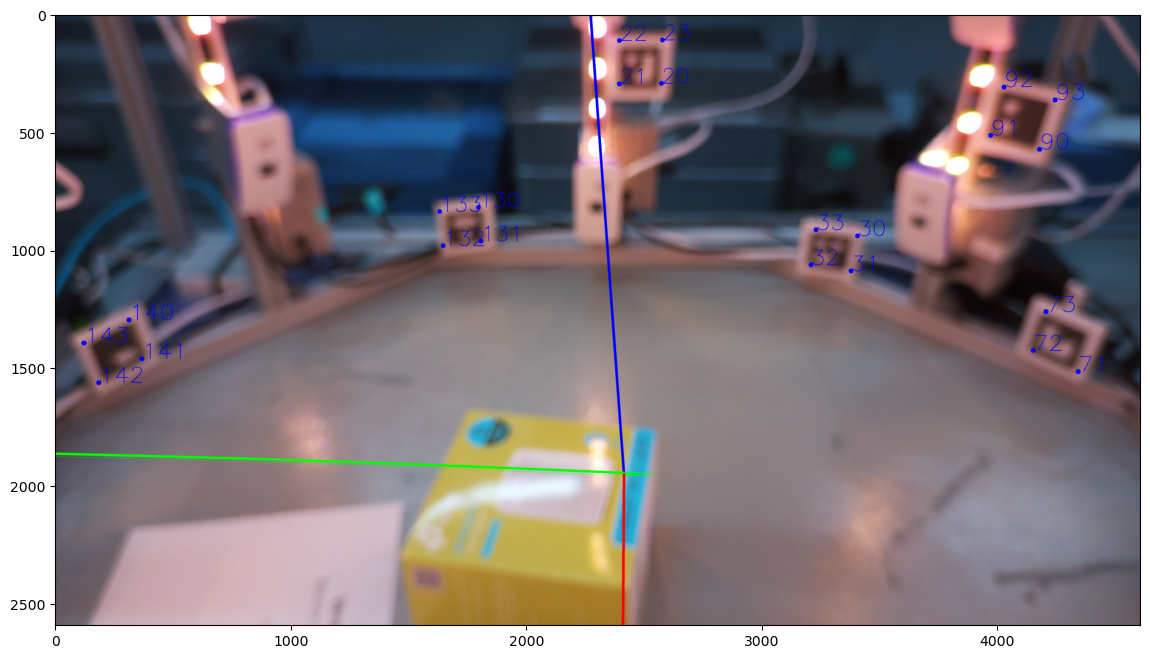

In [37]:
import matplotlib.pyplot as plt
nr = bilder.sample(1).index[0]
print(nr)
imgCV = cv2.imread(bilder.iloc[nr].path)

bild = bilder.loc[nr]
print(bild)
cam = cameras.loc[bild.camera]
print(cam)
r = cam[['rx', 'ry', 'rz']].to_numpy(dtype=np.float64)
t = cam[['tx', 'ty', 'tz']].to_numpy(dtype=np.float64).T

mtx, dist = calibrate(bilder.iloc[nr].focus, vz_param)
for key, p in aruco[aruco["image"] == nr].iterrows():
    cv2.circle(imgCV, (int(p["x"]), int(p["y"])), 10, (255, 0, 0), -1)
    cv2.putText(imgCV, str(
        int(key)), (int(p["x"]), int(p["y"])),  cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)
img_points, _ = cv2.projectPoints(
    coords[["wx", "wy", "wz"]].to_numpy(), r, t, mtx, dist)
for c, p in zip(coords.reset_index()['marker'].values, img_points):
    try:
        cv2.circle(imgCV, (int(p[0][0]), int(
            p[0][1])), 10, (0, 0, 255), -1)
        cv2.putText(imgCV, str(c), (int(p[0][0]), int(
            p[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 2)
    except:
        pass
"""
for i, row in coords.iterrows():
    cameraMatrix, distCoeffs = calibrate(
        row["focus"], vz_param)
    pts = row[["cx", "cy"]].values
    print(pts)
    ip, _ = cv2.projectPoints(
        np.array(pos[row["marker"]]], np.float32), r, t, cameraMatrix, distCoeffs)
    cv2.circle(imgCV, (int(row['x']), int(
        row['y'])), 10, (0, 0, 255), -1)

cam_points, _ = cv2.projectPoints(
    picWC[['x', 'y', 'z']].values, r, t, mtx, dist)
for c, p in zip(picWC.reset_index()['img'].values, cam_points):
    if nr == c:
        continue
    try:
        cv2.circle(imgCV, (int(p[0][0]), int(
            p[0][1])), 10, (0, 255, 0), -1)
        cv2.putText(imgCV, str(c+1), (int(p[0][0]), int(
            p[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 2)
    except:
        pass
        """
cv2.drawFrameAxes(imgCV, mtx, dist, r, t, 10, 10)
imgCV = cv2.undistort(imgCV, mtx, dist)
plt.figure(figsize=(14, 11))
plt.imshow(imgCV)
plt.show()

In [38]:
joined_df

,point_id,image,point_idx,path,camera,focus,x,y
0,92275,69,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,5.0,37.025242,1373.879028
1,71422,92,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,6.0,37.656891,1085.415527
2,71658,115,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,10.0,163.523376,1202.720093
3,71249,115,0,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,10.0,163.523376,1202.720093
4,71422,46,1,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,4.0,47.113457,1087.628296
...,...,...,...,...,...,...,...,...
123648,70116,68,7866,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0,4597.042480,2018.774902
123649,70117,68,7871,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0,4597.765137,1977.595459
123650,70119,68,7882,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0,4599.907227,2000.318848
123651,70118,68,7887,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0,4600.082520,2073.079346


In [39]:
merge = joined_df.merge(
    joined_df, on=['point_id'], suffixes=('_1', '_2'))
merge = merge[merge.camera_1 < merge.camera_2]
merge

,point_id,image_1,point_idx_1,path_1,camera_1,focus_1,x_1,y_1,image_2,point_idx_2,path_2,camera_2,focus_2,x_2,y_2
597,850,46,19,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,4.0,296.971680,2478.825684,24,53,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,3.0,129.792770,2457.772217
598,850,46,19,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,4.0,296.971680,2478.825684,24,69,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,3.0,150.662384,2440.474854
599,850,46,19,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,4.0,296.971680,2478.825684,24,103,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,3.0,210.253723,2581.620361
600,850,46,19,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,4.0,296.971680,2478.825684,24,104,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,3.0,212.203552,2465.957275
601,850,46,19,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,4.0,296.971680,2478.825684,24,111,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,3.0,231.800797,2450.587646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393530,36154,21,11792,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,23,1.0,3628.341797,1046.238647,22,2346,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,1.0,3571.584229,1089.546631
393894,68877,44,14553,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,23,3.0,3545.873047,570.022156,114,4279,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,6.0,3563.701660,633.564453
393918,36155,21,14771,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,23,1.0,4395.089844,1033.415894,22,2929,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,1.0,4476.875488,1070.422241
393958,68478,44,15199,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,23,3.0,4045.300537,2010.455933,68,5178,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0,3962.244873,1942.479980


In [40]:
err = merge.groupby(['image_1', 'image_2', 'point_id']).size(
).reset_index().sort_values(0, ascending=False)
err = err[err[0] > 1]
merge = merge.merge(err, on=['image_1', 'image_2',
                    'point_id'], how='left')
merge = merge.drop(index=merge[merge[0] > 1].index).drop(columns=0)
merge

,point_id,image_1,point_idx_1,path_1,camera_1,focus_1,x_1,y_1,image_2,point_idx_2,path_2,camera_2,focus_2,x_2,y_2
745,1091,115,22,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,10.0,818.895691,79.170486,3,2163,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,4,1.0,710.680847,142.837540
746,1091,69,30,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,5.0,827.653137,80.334717,3,2163,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,4,1.0,710.680847,142.837540
747,1091,0,3734,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,893.225220,106.319458,3,2163,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,4,1.0,710.680847,142.837540
748,2016,115,23,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,10.0,834.523682,836.590942,1,1723,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,1.0,967.352173,827.880005
749,2016,115,23,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,10.0,834.523682,836.590942,5,1017,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,6,1.0,916.658691,850.223877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24313,36154,21,11792,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,23,1.0,3628.341797,1046.238647,22,2346,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,1.0,3571.584229,1089.546631
24314,68877,44,14553,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,23,3.0,3545.873047,570.022156,114,4279,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,6.0,3563.701660,633.564453
24315,36155,21,14771,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,23,1.0,4395.089844,1033.415894,22,2929,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,1.0,4476.875488,1070.422241
24316,68478,44,15199,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,23,3.0,4045.300537,2010.455933,68,5178,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0,3962.244873,1942.479980


In [41]:
best = merge.groupby(['image_1', 'image_2']).size(
).reset_index().sort_values(0, ascending=False)
best

,image_1,image_2,0
1054,32,33,222
422,9,10,200
1049,32,10,195
428,9,33,185
188,3,4,164
...,...,...,...
2241,86,134,1
361,7,14,1
2239,86,114,1
2238,86,113,1


In [42]:
projections = {}
for i, row in cameras.iterrows():
    rvec = row[['rx', 'ry', 'rz']].to_numpy(dtype=np.float64)
    tvec = row[['tx', 'ty', 'tz']].to_numpy(dtype=np.float64)

    R, _ = cv2.Rodrigues(rvec)

    projections[i] = np.c_[R, tvec]

In [43]:
from funktionen import *

In [44]:
liste = []
for _, row in best.iterrows():
    img1 = bilder.iloc[row["image_1"]]
    img2 = bilder.iloc[row["image_2"]]

    p1 = projections[img1["camera"]]
    p2 = projections[img2["camera"]]

    mtx1, dist1 = calibrate(img1["focus"])
    mtx2, dist2 = calibrate(img2["focus"])

    points = merge[(merge["image_1"] == row["image_1"]) & (
        merge["image_2"] == row["image_2"])][["point_id", "x_1", "y_1", "x_2", "y_2"]].set_index("point_id")
    ud1 = cv2.undistortPoints(
        points[["x_1", "y_1"]].to_numpy().reshape(-1, 1, 2), mtx1, dist1)
    ud2 = cv2.undistortPoints(
        points[["x_2", "y_2"]].to_numpy().reshape(-1, 1, 2), mtx2, dist2)

    p = cv2.triangulatePoints(p1, p2, ud1, ud2)
    p = (p/p[-1])[:3]

    rvec1 = p1[:, :3]
    tvec1 = p1[:, 3]
    diff1, _ = cv2.projectPoints(p, rvec1, tvec1, mtx1, dist1)
    diff1 = diff1.reshape(-1, 2)-points[["x_1", "y_1"]].to_numpy()
    diff1 = np.linalg.norm(diff1, axis=1) < 20
    neupunkte = np.c_[points.index.to_numpy(), p.T]

    merge.loc[(merge["image_1"] == row["image_1"]) & (
        merge["image_2"] == row["image_2"]), "inlier"] = diff1

    neupunkte = neupunkte[diff1]
    liste.extend(list(neupunkte))

In [45]:
merge

,point_id,image_1,point_idx_1,path_1,camera_1,focus_1,x_1,y_1,image_2,point_idx_2,path_2,camera_2,focus_2,x_2,y_2,inlier
745,1091,115,22,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,10.0,818.895691,79.170486,3,2163,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,4,1.0,710.680847,142.837540,True
746,1091,69,30,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,5.0,827.653137,80.334717,3,2163,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,4,1.0,710.680847,142.837540,True
747,1091,0,3734,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,1.0,893.225220,106.319458,3,2163,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,4,1.0,710.680847,142.837540,True
748,2016,115,23,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,10.0,834.523682,836.590942,1,1723,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,1.0,967.352173,827.880005,False
749,2016,115,23,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,10.0,834.523682,836.590942,5,1017,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,6,1.0,916.658691,850.223877,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24313,36154,21,11792,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,23,1.0,3628.341797,1046.238647,22,2346,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,1.0,3571.584229,1089.546631,False
24314,68877,44,14553,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,23,3.0,3545.873047,570.022156,114,4279,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,6.0,3563.701660,633.564453,False
24315,36155,21,14771,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,23,1.0,4395.089844,1033.415894,22,2929,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,1.0,4476.875488,1070.422241,False
24316,68478,44,15199,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,23,3.0,4045.300537,2010.455933,68,5178,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,24,4.0,3962.244873,1942.479980,False


In [103]:
p = pd.DataFrame(liste, columns=["point_id", "x", "y", "z"]).astype(
    {"point_id": int})
p

,point_id,x,y,z
0,8785,0.318173,-0.310763,0.073874
1,8786,0.318173,-0.310763,0.073874
2,8791,-0.192018,-0.234655,0.124718
3,12165,-0.170290,-0.278732,0.243098
4,11893,-0.190927,-0.243930,0.271016
...,...,...,...,...
9594,25906,0.081697,0.008867,0.082976
9595,3641,0.109594,-0.006630,0.086813
9596,6992,-0.096787,-0.017336,0.173631
9597,11883,0.100610,-0.016741,0.072726


In [104]:

p = p.groupby("point_id").agg(['mean', 'std', 'size'])
threshold = 0.005
p = p[(p[('x', 'std')] < threshold) & (p[('y', 'std')] < threshold) & (
    p[('z', 'std')] < threshold) & (p[('x', 'size')] > 5)]
p

x                        y                        z  \
              mean       std size      mean       std size      mean   
point_id                                                               
46        0.202326  0.000741    8  0.347886  0.001789    8  0.083918   
651       0.114615  0.000843   21  0.301195  0.002704   21  0.056516   
685       0.106716  0.001123    8  0.353476  0.004642    8  0.155771   
701       0.158297  0.001551   30  0.328333  0.004228   30  0.095816   
1146      0.108277  0.001180    9  0.301036  0.003445    9  0.078030   
...            ...       ...  ...       ...       ...  ...       ...   
74279    -0.268361  0.004449    8 -0.129971  0.000359    8  0.039155   
74311    -0.220380  0.004415   12  0.179570  0.001213   12  0.052307   
79687    -0.093657  0.001762   12 -0.345974  0.001545   12  0.033703   
80916     0.355150  0.001391    7 -0.286241  0.003169    7  0.147489   
82002     0.014296  0.002661    7 -0.392591  0.003165    7  0.026881   

                         
               std size  
point_id                 
46        0.000425    8  
651       0.000832   21  
685       0.000945    8  
701       0.001656   30  
1146      0.001227    9  
...            ...  ...  
74279     0.002221    8  
74311     0.002108   12  
79687     0.000618   12  
80916     0.000495    7  
82002     0.002631    7  

[200 rows x 9 columns]

In [105]:
points = p[[('x', 'mean'), ('y', 'mean'), ('z', 'mean')]].droplevel(1, 1)
merge.merge(points, on='point_id', how='inner')

,point_id,image_1,point_idx_1,path_1,camera_1,focus_1,x_1,y_1,image_2,point_idx_2,path_2,camera_2,focus_2,x_2,y_2,inlier,x,y,z
0,1146,69,167,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,5.0,3747.210938,717.418091,70,257,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,5.0,3730.199707,815.461792,True,0.108277,0.301036,0.078030
1,1146,69,167,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,5.0,3747.210938,717.418091,93,316,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,6.0,3719.961182,818.551636,True,0.108277,0.301036,0.078030
2,1146,69,167,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,5.0,3747.210938,717.418091,1,13089,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,1.0,3679.961670,831.542725,True,0.108277,0.301036,0.078030
3,1146,92,226,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,6.0,3737.494141,720.811340,70,257,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,5.0,3730.199707,815.461792,True,0.108277,0.301036,0.078030
4,1146,92,226,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,1,6.0,3737.494141,720.811340,93,316,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,2,6.0,3719.961182,818.551636,True,0.108277,0.301036,0.078030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3348,30413,41,12184,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,20,3.0,3757.027832,913.438843,65,8219,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,21,4.0,3926.729492,854.780640,True,0.432988,-0.045538,0.085777
3349,30413,41,12184,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,20,3.0,3757.027832,913.438843,42,16203,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,21,3.0,3903.663330,861.395325,True,0.432988,-0.045538,0.085777
3350,30413,18,19656,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,20,1.0,3748.156006,916.346985,19,6717,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,21,1.0,3893.362793,863.220093,True,0.432988,-0.045538,0.085777
3351,30413,18,19656,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,20,1.0,3748.156006,916.346985,65,8219,/mnt/ssd_daten/Studium/MScGeodaesieGeoinformat...,21,4.0,3926.729492,854.780640,True,0.432988,-0.045538,0.085777


In [213]:
import plotly.graph_objs as go

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=cameras['wcx'], y=cameras['wcy'],
                z=cameras['wcz'], mode='markers', name='Original Points'),
    go.Scatter3d(x=points['x'], y=points['y'],
                 z=points['z'], mode='markers', name='Original Points', marker=dict(size=2))])

# Add labels to the plot
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title='Rotation and Translation Vectors in 3D')
fig.layout.scene.camera.projection.type = "orthographic"
fig.show()

In [131]:
arPos = {k: v for k, v in coords.iterrows()}

In [297]:
# cameras["f_offset"] = 0
# cameras["x_offset"] = 0
# cameras["y_offset"] = 0

In [298]:
number_cam_param = 9
number_point_param = 3


def fun2(x):
    vz_param = x[:9]
    pts = pd.DataFrame(x[9:9+len(point_ids)*3].reshape(-1, 3),
                       columns=["x", "y", "z"])
    pts["id"] = point_ids
    pts.set_index("id", inplace=True)
    cams = pd.DataFrame(x[9+len(point_ids)*3:].reshape(-1, number_cam_param),
                        columns=["f_offset", "x_offset", "y_offset", "rx", "ry", "rz", "tx", "ty", "tz"])
    cams["id"] = camera_ids
    cams.set_index("id", inplace=True)
    diff = []
    for (camera, image, focus), value in filtered.groupby(['camera', 'image', "focus"]):
        cameraMatrix, distCoeffs = calibrate(
            focus, vz_param, cams.loc[camera, "f_offset"], cams.loc[camera, "x_offset"], cams.loc[camera, "y_offset"])
        rvec = cams.loc[camera, ['rx', 'ry', 'rz']
                        ].to_numpy(dtype=np.float64)
        tvec = cams.loc[camera, ['tx', 'ty', 'tz']
                        ].to_numpy(dtype=np.float64)
        for key, row in value.iterrows():
            imgpoints, _ = cv2.projectPoints(
                np.array(pts.loc[row["point_id"]], np.float32), rvec, tvec, cameraMatrix, distCoeffs)
            d_ = imgpoints[0][0]-row[['x', 'y']].values
            diff.append(np.linalg.norm(d_))

    for (image), value in aruco[aruco["inlier"]].groupby(["image"]):
        bild = bilder.loc[image]
        cameraMatrix, distCoeffs = calibrate(
            bild.focus, vz_param, cams.loc[bild.camera, "f_offset"], cams.loc[bild.camera, "x_offset"], cams.loc[bild.camera, "y_offset"])
        rvec = cams.loc[bild.camera, ['rx', 'ry', 'rz']
                        ].to_numpy(dtype=np.float64)
        tvec = cams.loc[bild.camera, ['tx', 'ty', 'tz']
                        ].to_numpy(dtype=np.float64)
        for key, row in value.iterrows():
            imgpoints, _ = cv2.projectPoints(
                np.array(arPos[row["marker"]]), rvec, tvec, cameraMatrix, distCoeffs)
            d_ = imgpoints[0][0]-row[['x', 'y']].values
            diff.append(np.linalg.norm(d_))
    diff.append(cams["f_offset"].sum()*1000)
    return diff

In [299]:
filtered = joined_df.merge(points, on='point_id',
                           how='inner', suffixes=('', '_coord')).sort_values(['camera', 'image', "focus"])

In [300]:
x2 = np.hstack([vz_param, points[["x", "y", "z"]].values.flatten(),
               cameras[["f_offset", "x_offset", "y_offset", "rx", "ry", "rz", "tx", "ty", "tz"]].values.flatten()])
point_ids = points.index.to_numpy()
camera_ids = cameras.index.to_numpy()
filtered["inlier"] = np.array(fun2(x2)[:filtered.shape[0]]) < 50
filtered = filtered[filtered['inlier']]

In [301]:
points_ = points.reset_index().join(
    filtered, on=["point_id"], rsuffix="_filtered", how="left").set_index("point_id")[["x", "y", "z"]]
x2 = np.hstack([vz_param, points_[["x", "y", "z"]].values.flatten(),
               cameras[["f_offset", "x_offset", "y_offset", "rx", "ry", "rz", "tx", "ty", "tz"]].values.flatten()])
point_ids = points_.index.to_numpy()

In [302]:
A2 = lil_matrix(
    (len(filtered)+aruco[aruco["inlier"]].shape[0]+1, len(x2)), dtype=int)
i = 0
for key, row in filtered.sort_values(['camera', 'image', "focus"]).iterrows():
    id = np.where(point_ids == row["point_id"])[0][0]
    A2[i, :9] = 1
    A2[i, 9+id*3:9+id*3+3] = 1
    id = np.where(camera_ids == row["camera"])[0][0]
    A2[i, 9+len(point_ids)*3+id*number_cam_param:9+len(point_ids)*3 +
       id*number_cam_param+number_cam_param] = 1
    i += 1
for key, row in aruco[aruco["inlier"]].sort_values(['image']).iterrows():
    bild = bilder.loc[row["image"]]
    A2[i, :9] = 1
    id = np.where(camera_ids == bild["camera"])[0][0]
    A2[i, 9+len(point_ids)*3+id*number_cam_param:9 +
       len(point_ids)*3+id*number_cam_param+number_cam_param] = 1
    i += 1
A2[i, 9+len(point_ids)*3::number_cam_param] = 1

In [303]:
A2.shape

(2268, 816)

In [304]:
res2 = least_squares(fun2, x2, verbose=2, jac_sparsity=A2,
                     x_scale='jac', method='trf', xtol=1e-5, loss='huber')

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7031e+04                                    6.07e+05    
       1             21         1.7023e+04      8.24e+00       3.11e-01       7.21e+05    
       2             22         1.7013e+04      1.02e+01       6.41e-02       7.31e+05    
       3             23         1.7006e+04      7.15e+00       6.31e-02       6.19e+05    
       4             24         1.7003e+04      2.30e+00       1.42e-02       4.43e+05    
       5             25         1.7001e+04      2.44e+00       1.42e-02       7.05e+05    
       6             26         1.6999e+04      1.94e+00       1.44e-02       6.42e+05    
       7             27         1.6998e+04      5.20e-01       3.49e-03       5.95e+05    
       8             28         1.6998e+04      3.96e-01       4.02e-03       6.98e+05    
       9             29         1.6998e+04      1.08e-01       8.88e-04       5.34e+05    

In [305]:
res2.x[:9]

array([ 2.63572488e+01,  6.31322513e-01, -9.88069511e+00,  2.92706002e+01,
       -4.15690296e-03, -1.99188205e-02, -1.01408404e-04,  2.60612862e-06,
        2.79208519e-02])

In [306]:
x2[:9]

array([ 2.63572488e+01,  6.31322513e-01, -9.88069511e+00,  2.92706002e+01,
       -4.15690296e-03, -1.99188205e-02, -1.01408404e-04,  2.60612862e-06,
        2.79208519e-02])

In [308]:
points[["x", "y", "z"]] = res2.x[9:9+len(point_ids)*3].reshape(-1, 3)

In [310]:
cameras[["f_offset", "x_offset", "y_offset", "rx", "ry", "rz", "tx", "ty", "tz"]
        ] = res2.x[9+len(point_ids)*3:].reshape(-1, number_cam_param)

In [311]:
f_offset = pd.DataFrame(
    res2.x[9+len(point_ids)*3:].reshape(-1, number_cam_param)[:, 0], columns=["f_offset"])
f_offset["id"] = camera_ids
f_offset["std"] = perr[9+len(point_ids)*3:].reshape(-1, number_cam_param)[:, 0]
f_offset.set_index("id", inplace=True)
f_offset

ValueError: cannot reshape array of size 161 into shape (9)

In [312]:
f_offset["f_offset"].sum()

2.3292404556284147e-20

In [313]:
from scipy import linalg
jac2 = res2.jac.todense()
cov2 = linalg.pinv(jac2.T @ jac2)
chi2dof2 = np.sum(res2.fun**2)/(res2.fun.size - res2.x.size)
cov2 *= chi2dof2
perr2 = np.sqrt(abs(np.diag(cov2)))
pd.DataFrame(perr2)

,0
0,0.000028
1,0.000021
2,0.000009
3,0.000099
4,0.010757
...,...
811,0.000168
812,0.000322
813,0.000473
814,0.001898


In [314]:
np.array(fun2(x2)).sum()

18159.548748443813

In [315]:
np.array(fun2(res2.x)).sum()

18125.82243230809

In [316]:
vz_param

[26.3572488,
 0.631322513,
 -9.88069511,
 29.2706002,
 -0.00415690296,
 -0.0199188205,
 -0.000101408404,
 2.60612862e-06,
 0.0279208519]

In [317]:
res2.x[:9]

array([ 2.63572488e+01,  6.31322513e-01, -9.88069511e+00,  2.92706002e+01,
       -4.15690296e-03, -1.99188205e-02, -1.01408404e-04,  2.60612862e-06,
        2.79208519e-02])

In [318]:
cameras

,tx,ty,tz,rx,ry,rz,wcx,wcy,wcz,f_offset,x_offset,y_offset
camera,,,,,,,,,,,,
1,-0.022570,0.049294,0.565367,2.116011,0.816013,-0.364859,0.283883,-0.298801,0.390879,1.092693e-22,-1.865330e-01,-1.274227e-01
2,-0.046734,0.055439,0.484146,1.901436,0.734019,-0.459678,0.311512,-0.278156,0.25541,-2.295734e-21,-3.847685e-16,-1.809465e-15
3,-0.065907,0.079897,0.405285,1.413819,0.611008,-0.624267,0.33835,-0.239661,0.055364,6.142741e-22,3.562992e-16,-3.667826e-15
4,0.017297,0.103264,0.572861,1.637168,1.598118,-0.862375,0.422387,-0.028789,0.399866,7.705296e-22,7.940345e-13,-2.887236e-15
5,0.016922,0.076952,0.495608,1.490796,1.468722,-0.991139,0.431461,-0.025542,0.254999,8.577614e-21,-6.410044e-15,-3.022919e-16
6,0.019642,0.074172,0.421031,1.193862,1.170281,-1.216319,0.422982,-0.026124,0.059651,3.231468e-22,-1.132541e-01,6.047757e-02
7,0.106170,0.126822,0.629902,1.015619,2.423861,-1.086157,0.339436,0.20121,0.518341,7.929432e-22,5.077716e-02,1.040529e-01
9,0.173910,0.068425,0.398166,1.142755,1.804947,-1.348165,0.397127,0.008528,0.188892,4.714834e-23,-1.821159e-15,-1.130828e-16
10,0.110531,0.133470,0.503027,-0.006390,2.847223,-1.335242,0.108525,0.301951,0.424401,-3.257810e-22,3.230431e-16,2.819671e-16


In [323]:
reste = fun2(res2.x)

In [325]:
cameras.to_csv(
    "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/cameras.csv")
points.to_csv(
    "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/points.csv")
pd.DataFrame(vz_param).to_csv(
    "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/vz_param.csv")
aruco.to_csv(
    "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/aruco.csv")
bilder.to_csv(
    "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/bilder.csv")
coords.to_csv(
    "/mnt/ssd_daten/Studium/MScGeodaesieGeoinformatik/4_Thesis/bilderserien/TPKarton/coords.csv")